In [2]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import numba as nb
import imageio
import shutil
import sys
import os

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

In [7]:
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
alphaRate = 0.9
scale = 35
width = 0.003

def draw_mp4(sa: StateAnalysis, fileName: str, mp4Path: str = "./normalMP4", step: int = 1, tailCounts: int = None):
    
    def plot_frame(i):
        pbar.update(1)
        fig.clear()
        ax = plt.subplot(1, 1, 1)
        singlePositionX, singlePhaseTheta, _ = sa.get_state(index=i)
        omegaTheta = sa.model.omegaTheta
        if isinstance(sa.model, SingleDistribution):
            ax.quiver(
                singlePositionX[:, 0], singlePositionX[:, 1],
                np.cos(singlePhaseTheta[:]), np.sin(singlePhaseTheta[:]), 
                color=[cmap(i) for i in (omegaTheta - 1) / 2], alpha=1,
                scale=23, width=0.005
            )
        elif isinstance(sa.model, SpatialGroups):
            ax.quiver(
                singlePositionX[class1, 0], singlePositionX[class1, 1],
                np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', 
                # alpha = (1 - alphaRate) + (np.abs(omegaTheta[class1]) - 1) / 2 * alphaRate,
                scale=scale, width=width
            )
            ax.quiver(
                singlePositionX[class2, 0], singlePositionX[class2, 1],
                np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='#414CC7', 
                # alpha = (1 - alphaRate) + (np.abs(omegaTheta[class2]) - 1) / 2 * alphaRate,
                scale=scale, width=width
            )
        strengthLambda = np.round(sa.model.strengthLambda, 3)
        distanceD0 = np.round(sa.model.distanceD0, 2)
        ax.set_title(f"$\lambda={strengthLambda},\ d_0={distanceD0}$", fontweight="bold")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()

    fig, _ = plt.subplots(1, 1, figsize=(4, 4))
    TNum = sa.TNum
    startIdx = TNum - tailCounts * step if tailCounts else 0
    frames = np.arange(startIdx, TNum, step)
    pbar = tqdm(total=len(frames))
    ani = ma.FuncAnimation(fig, plot_frame, frames=frames, interval=40, repeat=False)
    ani.save(f"{mp4Path}/{fileName}.mp4", dpi=200)
    plt.close()
    pbar.close()

def draw_mp4s(sas: List[StateAnalysis], fileName: str, mp4Path: str = "./normalMP4", step: int = 1, tailCounts: int = None):
    
    def plot_frame(i):
        pbar.update(1)
        fig.clear()
        for idx in range(len(sas)):
            ax = plt.subplot(rowNum, 3, idx + 1)
            sa = sas[idx]
            singlePositionX, singlePhaseTheta, _ = sa.get_state(index=i)
            omegaTheta = sa.model.omegaTheta
            if isinstance(sa.model, SingleDistribution):
                ax.quiver(
                    singlePositionX[:, 0], singlePositionX[:, 1],
                    np.cos(singlePhaseTheta[:]), np.sin(singlePhaseTheta[:]), 
                    color=[cmap(i) for i in (omegaTheta - 1) / 2], alpha=1,
                    scale=23, width=0.005
                )
            elif isinstance(sa.model, SpatialGroups):
                ax.quiver(
                    singlePositionX[class1, 0], singlePositionX[class1, 1],
                    np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', 
                    # alpha = (1 - alphaRate) + (np.abs(omegaTheta[class1]) - 1) / 2 * alphaRate,
                    scale=scale, width=width
                )
                ax.quiver(
                    singlePositionX[class2, 0], singlePositionX[class2, 1],
                    np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='#414CC7', 
                    # alpha = (1 - alphaRate) + (np.abs(omegaTheta[class2]) - 1) / 2 * alphaRate,
                    scale=scale, width=width
                )
            strengthLambda = np.round(sa.model.strengthLambda, 3)
            distanceD0 = np.round(sa.model.distanceD0, 2)
            ax.set_title(f"({chr(65 + idx).lower()})  $\lambda={strengthLambda},\ d_0={distanceD0}$", fontweight="bold")
            ax.set_xlim(0, 10)
            ax.set_ylim(0, 10)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()

    rowNum = len(sas) // 3
    fig, axs = plt.subplots(rowNum, 3, figsize=(10, rowNum * 4))
    axs = axs.flatten()
    TNum = sas[0].TNum
    startIdx = TNum - tailCounts * step if tailCounts else 0
    frames = np.arange(startIdx, TNum, step)
    pbar = tqdm(total=len(frames))
    ani = ma.FuncAnimation(fig, plot_frame, frames=frames, interval=40, repeat=False)
    ani.save(f"{mp4Path}/{fileName}.mp4", dpi=200)
    plt.close()
    pbar.close()

In [41]:
models = [
    SpatialGroups(strengthLambda=0.015, distanceD0=0.25, randomSeed=10, savePath="./data"),
    SpatialGroups(strengthLambda=0.015, distanceD0=0.35, randomSeed=10, savePath="./data"),
    SpatialGroups(strengthLambda=0.015, distanceD0=0.9, randomSeed=10, savePath="./data")
]
sas = [StateAnalysis(model) for model in models]
draw_mp4s(sas, "V#8~10_chiral_CS", tailCounts=750, step=1)

  0%|          | 0/750 [00:00<?, ?it/s]

In [42]:
models = [
    SpatialGroups(strengthLambda=0.1, distanceD0=0.45, randomSeed=10, savePath="./data"),
    SpatialGroups(strengthLambda=0.1, distanceD0=0.75, randomSeed=10, savePath="./data"),
    SpatialGroups(strengthLambda=0.1, distanceD0=1.5, randomSeed=10, savePath="./data")
]
sas = [StateAnalysis(model) for model in models]
draw_mp4s(sas, "V#11~13_chiral_CLS", tailCounts=750, step=1)

  0%|          | 0/750 [00:00<?, ?it/s]

In [44]:
models = [
    SingleDistribution(strengthLambda=0.01, distanceD0=0.35, randomSeed=10, savePath="./data"),
    SingleDistribution(strengthLambda=0.01, distanceD0=0.65, randomSeed=10, savePath="./data"),
    SingleDistribution(strengthLambda=0.01, distanceD0=1.05, randomSeed=10, savePath="./data")
]
sas = [StateAnalysis(model) for model in models]
draw_mp4s(sas, "V#2~4_monoChiral_CS", tailCounts=750, step=1)

  0%|          | 0/750 [00:00<?, ?it/s]

In [43]:
models = [
    SingleDistribution(strengthLambda=0.15, distanceD0=0.5, randomSeed=10, savePath="./data"),
    SingleDistribution(strengthLambda=0.15, distanceD0=0.85, randomSeed=10, savePath="./data"),
    SingleDistribution(strengthLambda=0.15, distanceD0=0.95, randomSeed=10, savePath="./data")
]
sas = [StateAnalysis(model) for model in models]
draw_mp4s(sas, "V#5~7_monoChiral_CLS", tailCounts=750, step=1)

  0%|          | 0/750 [00:00<?, ?it/s]

In [10]:
model = SingleDistribution(strengthLambda=0, distanceD0=0, randomSeed=10, savePath="./data", overWrite=True, tqdm=True, boundaryLength=10)
sa = StateAnalysis(model)
draw_mp4(sa, "V#1_monoChiral_lambda0", tailCounts=750, step=1)

  0%|          | 0/750 [00:00<?, ?it/s]

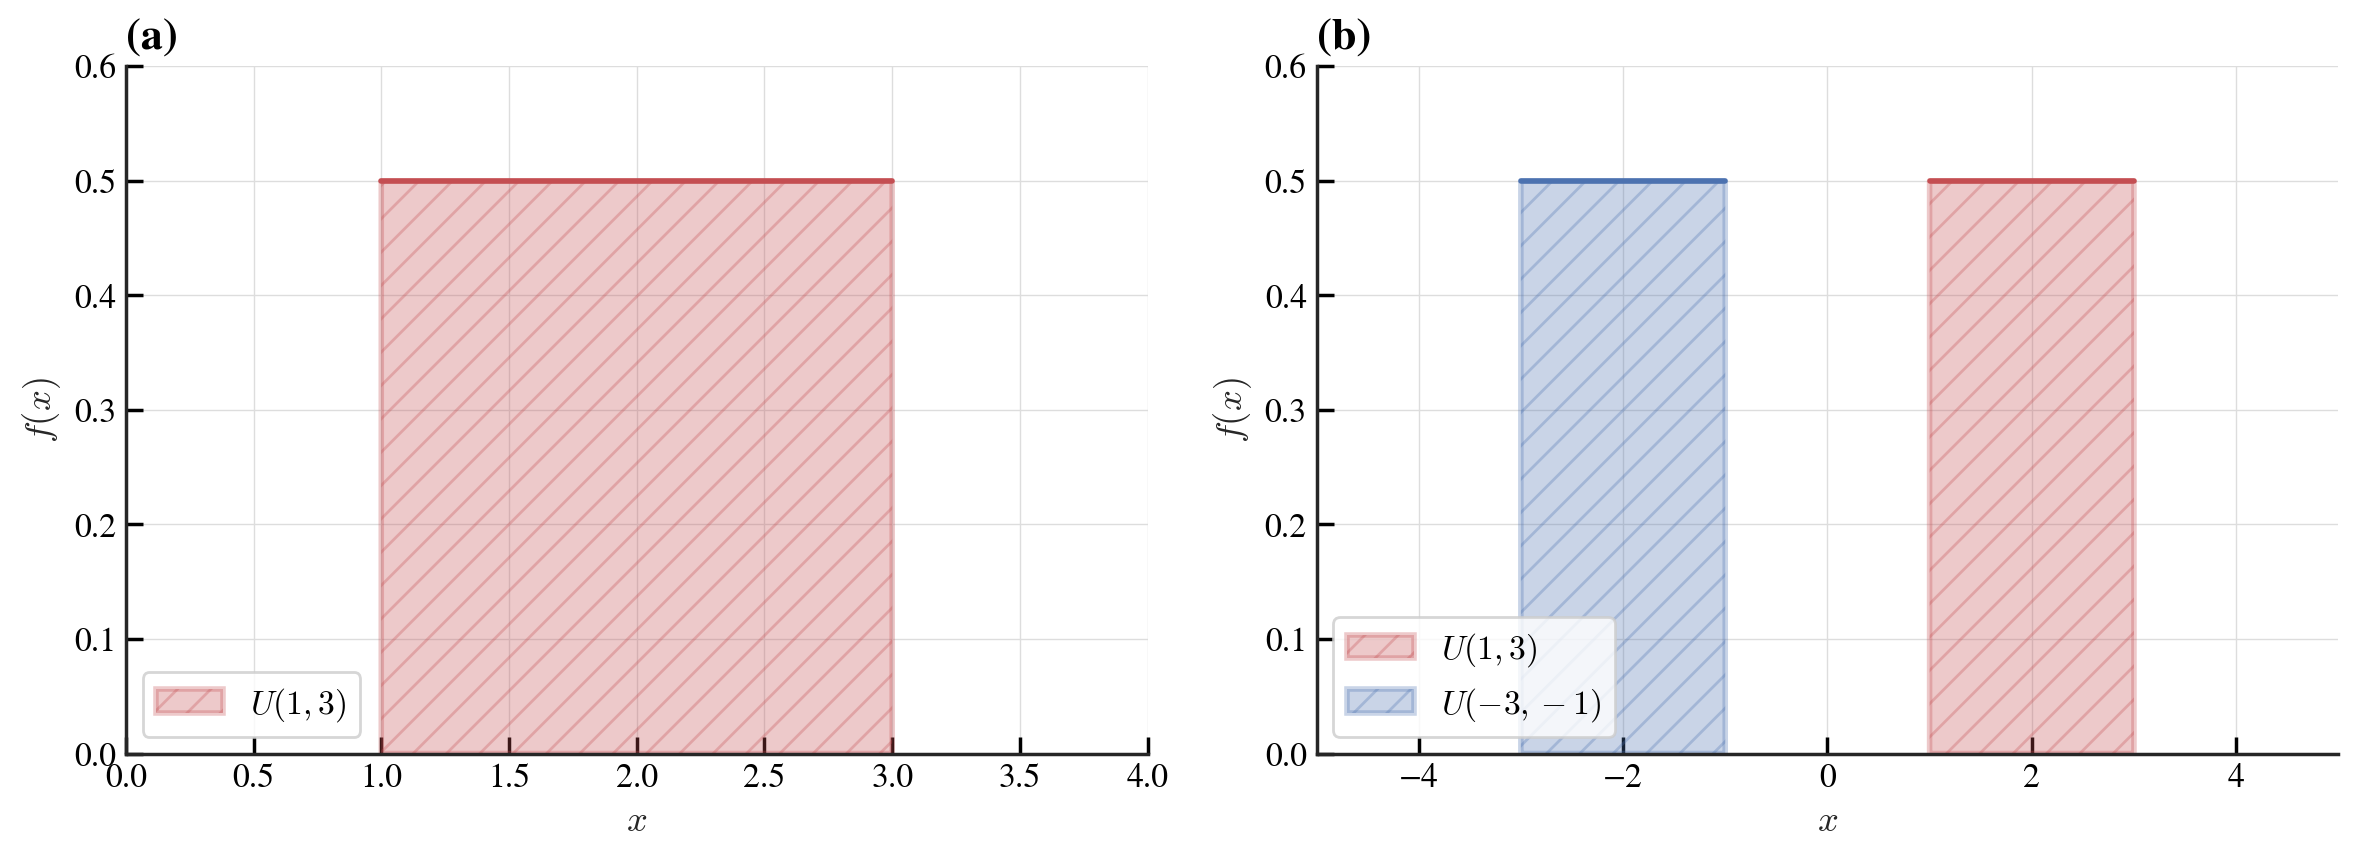

In [79]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

ax1, ax2 = axs

a0, b0 = 1, 3
x0 = np.linspace(a0, b0, 1000)
ax1.plot(x0, np.ones_like(x0) * (1 / (b0 - a0)), 'r', linewidth=2)
ax1.fill_between(x0, 0, np.ones_like(x0) * (1 / (b0 - a0)), linewidth=2, color='r', alpha=0.3, hatch='//', label=r"$U(1,3)$")

ax1.set_xlim(0, 4)
ax1.set_ylim(0, 0.6)
ax1.grid(True)
ax1.legend(loc='lower left')
ax1.set_title("(a)", loc='left', fontweight='bold', fontsize=16)

a1, b1 = 1, 3
x1 = np.linspace(a1, b1, 1000)
ax2.plot(x1, np.ones_like(x1) * (1 / (b1 - a1)), 'r', linewidth=2)
ax2.fill_between(x1, 0, np.ones_like(x1) * (1 / (b1 - a1)), linewidth=2, color='r', alpha=0.3, hatch='//', label=r"$U(1,3)$")

a2, b2 = -3, -1
x2 = np.linspace(a2, b2, 1000)
ax2.plot(x2, np.ones_like(x2) * (1 / (b2 - a2)), 'b', linewidth=2)
ax2.fill_between(x2, 0, np.ones_like(x2) * (1 / (b2 - a2)), linewidth=2, color='b', alpha=0.3, hatch='//', label=r"$U(-3,-1)$")

ax2.set_xlim(-5, 5)
ax2.set_ylim(0, 0.6)
ax2.grid(True)
ax2.legend()
ax2.set_title("(b)", loc='left', fontweight='bold', fontsize=16)

for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.tick_params(direction='in')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

plt.tight_layout()
# plt.show()
plt.savefig("./normalMP4/Fig1_freq_distri.png", dpi=200, bbox_inches='tight')